<center>
<h1>Fake news detection using graph neural network</h1>
<h2>SAGE GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all, val_step
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('./data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class SAGE(torch.nn.Module):
    
    
    def __init__(self, num_n_feature, num_g_feature, emb_size, num_layers=2):
        super(SAGE, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            size_in = num_n_feature if i == 0 else emb_size
            self.convs.append(SAGEConv(size_in, emb_size))

        # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)


    
    def forward(self, x, edges_idx, batch_idx, g_features):
        for i, conv in enumerate(self.convs):
            x = conv(x, edges_idx)
            if i != len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
            else:
                
                flatten = torch.cat([global_mean_pool(x, batch_idx),
                                     global_max_pool(x, batch_idx)], axis=1)

                if g_features.size()[-1]>1:
                    g_ft = self.lin_g(g_features)
                    flatten = torch.cat([flatten, g_ft], axis=1)

                out = self.act(self.out_layer(flatten))
                
        return out

# Training

In [4]:
models = train_all(SAGE, datasets, emb_size=100, epochs=100, lr=0.001, wd=0.01, batch_size=128)

--> Train on: origin


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.3838322162628174  loss_val=0.4532133638858795 | acc_train=0.8530433006535948  acc_val=0.8016544117647058
Epochs: 20 | loss_train=0.32396509912278915  loss_val=0.4204436480998993 | acc_train=0.8674428104575163  acc_val=0.8338235294117646
Epochs: 30 | loss_train=0.31672246257464093  loss_val=0.40554831027984617 | acc_train=0.8672385620915032  acc_val=0.8397058823529411
Epochs: 40 | loss_train=0.3046022206544876  loss_val=0.4785152554512024 | acc_train=0.8745404411764706  acc_val=0.7954963235294118
Epochs: 50 | loss_train=0.29861389100551605  loss_val=0.4870509207248688 | acc_train=0.8816891339869282  acc_val=0.7920955882352941
Epochs: 60 | loss_train=0.3042526642481486  loss_val=0.41607288718223573 | acc_train=0.877093545751634  acc_val=0.8479779411764706
Epochs: 70 | loss_train=0.28382301992840236  loss_val=0.4789463460445404 | acc_train=0.8826593137254902  acc_val=0.7959558823529411
Epochs: 80 | loss_train=0.28940582440959084  loss_val=0.5026316165924072 | acc

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.5082925226953294  loss_val=0.8836749196052551 | acc_train=0.7973345588235294  acc_val=0.5500919117647058
Epochs: 20 | loss_train=0.5963860948880514  loss_val=0.6218475937843323 | acc_train=0.7647569444444444  acc_val=0.6098345588235294
Epochs: 30 | loss_train=0.4814942843384213  loss_val=0.5904350757598877 | acc_train=0.816125408496732  acc_val=0.6344669117647059
Epochs: 40 | loss_train=0.45470142033365035  loss_val=0.5257731020450592 | acc_train=0.8158190359477124  acc_val=0.7736213235294118
Epochs: 50 | loss_train=0.44058720933066475  loss_val=0.5413897573947907 | acc_train=0.8106617647058824  acc_val=0.7501838235294118
Epochs: 60 | loss_train=0.4427056577470567  loss_val=0.5311097919940948 | acc_train=0.8229677287581699  acc_val=0.7446691176470589
Epochs: 70 | loss_train=0.4435914158821106  loss_val=0.5315783798694611 | acc_train=0.8022875816993464  acc_val=0.7959558823529411
Epochs: 80 | loss_train=0.41871867577234906  loss_val=0.5758703410625458 | acc_tra

  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.5291682581106821  loss_val=1.0869230270385741 | acc_train=0.7925347222222222  acc_val=0.5273897058823529
Epochs: 20 | loss_train=0.4533270796140035  loss_val=0.517814701795578 | acc_train=0.8134191176470588  acc_val=0.7548713235294118
Epochs: 30 | loss_train=0.4523749351501465  loss_val=0.8015848517417907 | acc_train=0.8105596405228758  acc_val=0.5888786764705882
Epochs: 40 | loss_train=0.47808166013823616  loss_val=0.635558259487152 | acc_train=0.8118872549019608  acc_val=0.5992647058823529
Epochs: 50 | loss_train=0.4242727922068702  loss_val=0.4733396112918854 | acc_train=0.8189338235294117  acc_val=0.8011029411764706
Epochs: 60 | loss_train=0.40876977973514134  loss_val=0.4960184633731842 | acc_train=0.831750408496732  acc_val=0.7841911764705882
Epochs: 70 | loss_train=0.41455058919058907  loss_val=0.5164122760295868 | acc_train=0.8292483660130718  acc_val=0.7931985294117647
Epochs: 80 | loss_train=0.4537312255965339  loss_val=0.6700387239456177 | acc_train

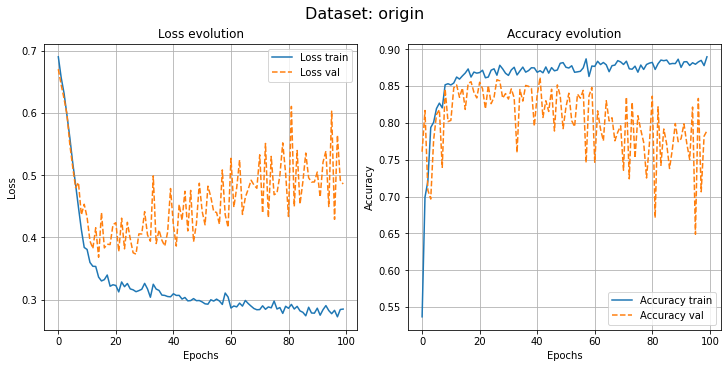

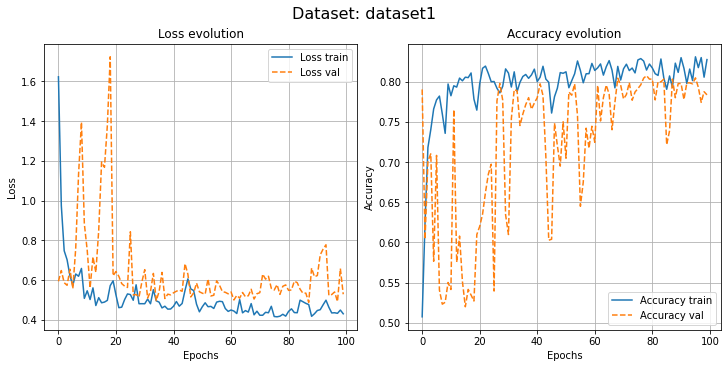

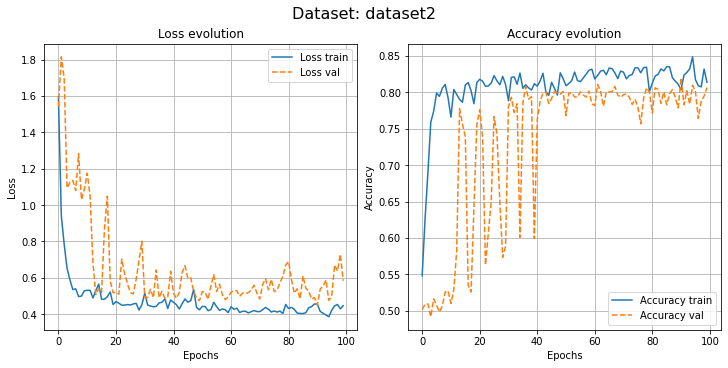

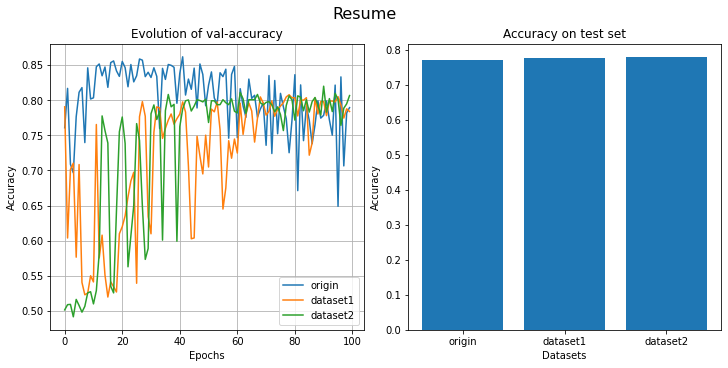

In [5]:
plot_hist(models)